<h1>Current Plot<h1>

<h3>Import<h3>

In [38]:
# IMPORTS

import numpy as np
import pandas as pd

import math as m
import statistics as stat

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import seaborn as sns
sns.set_theme()


<h3>Plot<h3>

Laplace average field: 141.359 MV/m
Image charge average field: 144.960 MV/m
RMSD: 20.029 MV/m
RMSD relative to average: 13.817 %
RMSD relative to norm: 5.617 %
RMSDIQR: 24.621 %
NRMSD: 0.703 %
Mean absolute percentage deviation: 37.320 %
Filtered mean absolute percentage deviation: 30.680 %


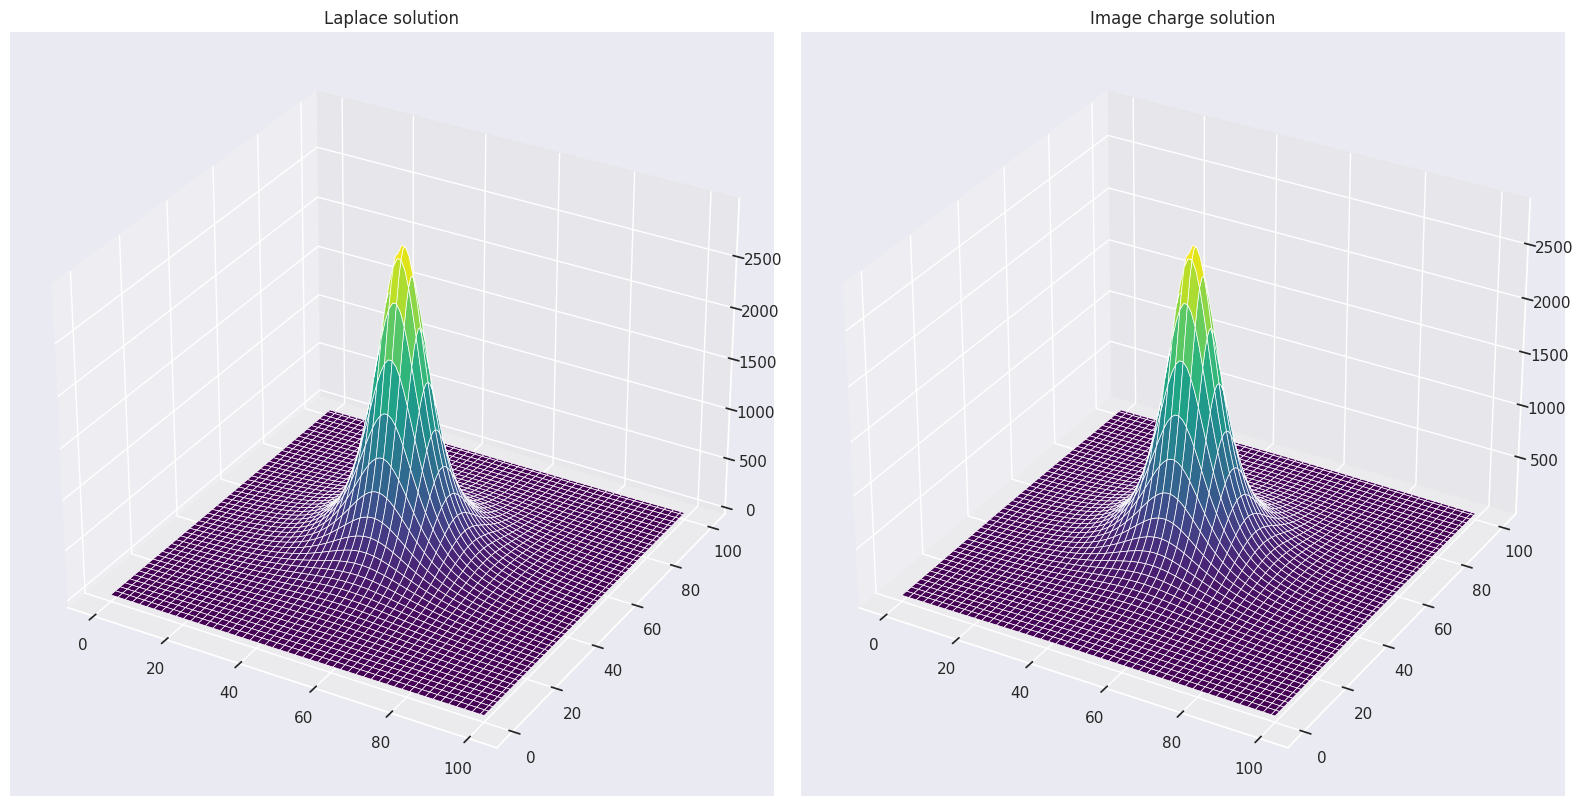

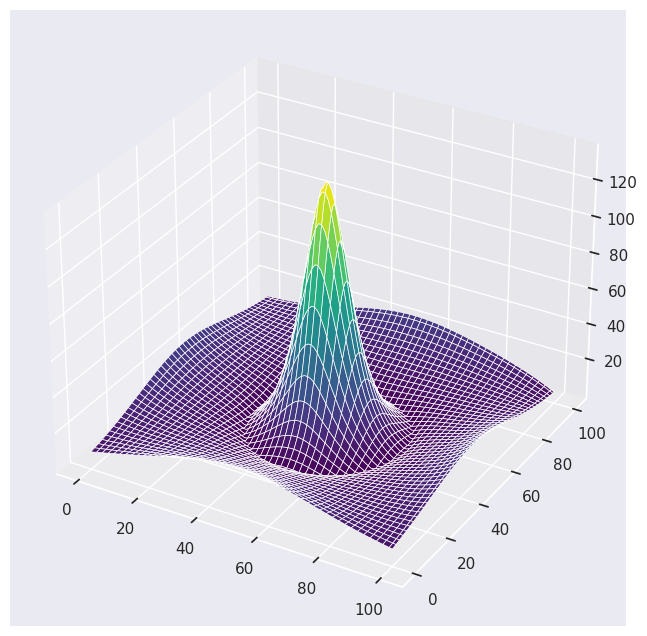

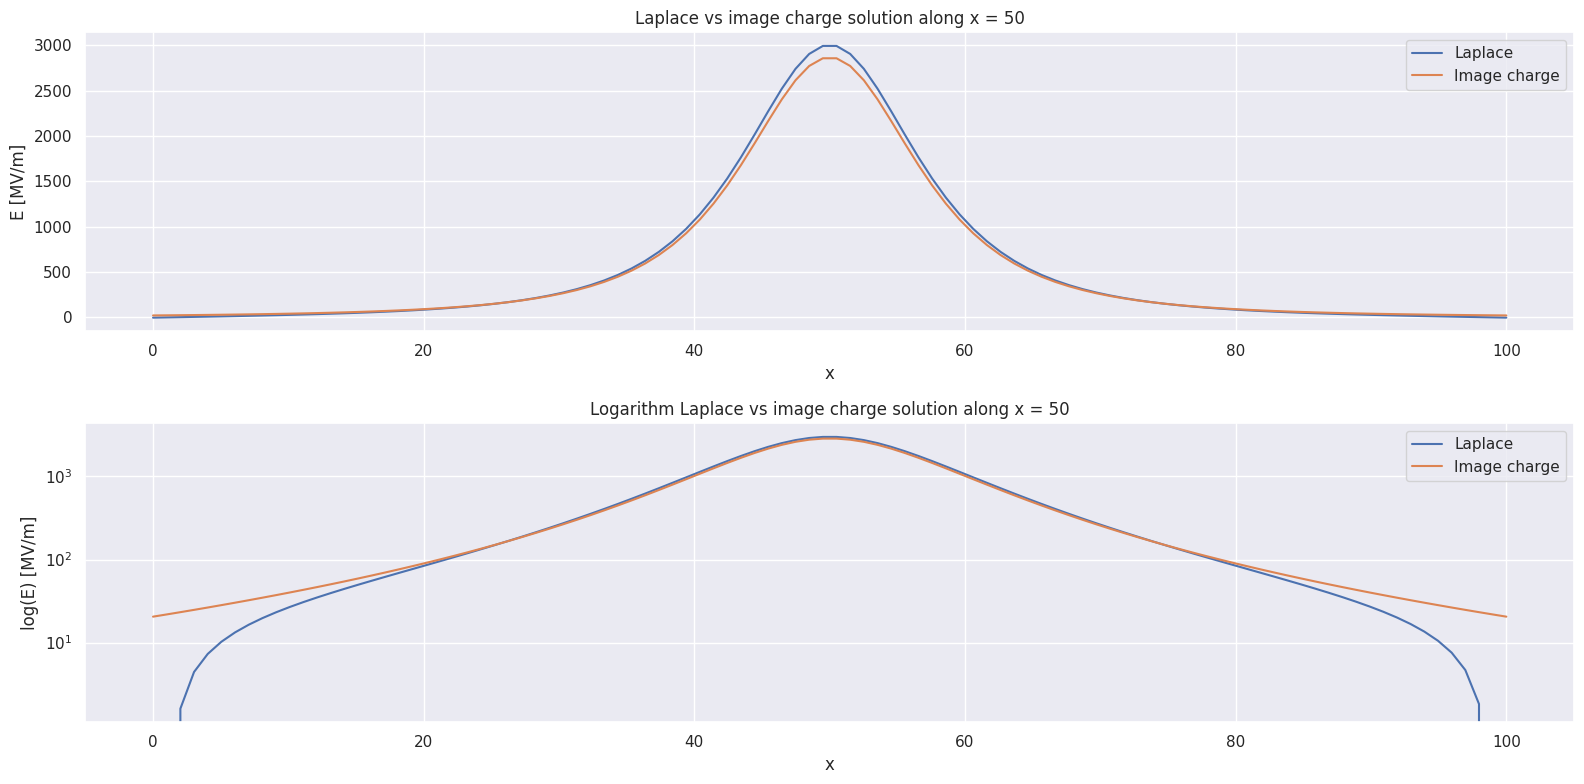

In [39]:
# Memory map file
lp_filename = f'./out/lp_field_0.bin'
lp_dt_abs_type = np.dtype([('i', np.int64), ('j', np.int64), ('field', np.float64), ('emit',np.int64)])
lp_data_mem_abs = np.memmap(lp_filename, dtype=lp_dt_abs_type, mode='r', order='F')
lp_data = pd.DataFrame.from_records(data=lp_data_mem_abs, columns=lp_data_mem_abs.dtype.names)

ic_filename = f'./out/ic_field_0.bin'
ic_dt_abs_type = np.dtype([('i', np.int64), ('j', np.int64), ('field', np.float64), ('emit',np.int64)])
ic_data_mem_abs = np.memmap(ic_filename, dtype=ic_dt_abs_type, mode='r', order='F')
ic_data = pd.DataFrame.from_records(data=ic_data_mem_abs, columns=ic_data_mem_abs.dtype.names)

msd = 0
mapd = 0
fmapd = 0 
fmpad = 0
Nx = 100; Ny = 100
lp_field = np.zeros((Nx,Ny))
ic_field = np.zeros((Nx,Ny))
x = np.linspace(0,Nx,Nx)
y = np.linspace(0,Ny,Ny)
X, Y = np.meshgrid(x,y)
X = X.T; Y = Y.T
for k in range(Nx*Ny):
    i = lp_data['i'][k]
    j = lp_data['j'][k]

    lp_field[i][j] = lp_data['field'][k]*1e-6
    ic_field[i][j] = ic_data['field'][k]*1e-6
    # print(i,j,lp_field[i][j])

for k in range(Nx*Ny):
    i = lp_data['i'][k]
    j = lp_data['j'][k]
    msd += (lp_field[i][j]-ic_field[i][j])**2/(Nx*Ny)
    mapd += abs((lp_field[i][j]-ic_field[i][j])/(ic_field[i][j]+1e-12))/(Nx*Ny)
    if (ic_field[i][j] > 0.1*ic_field.mean()):
        fmapd += abs((lp_field[i][j]-ic_field[i][j])/(ic_field[i][j]+1e-12))
        fmpad += 1

rmsd = m.sqrt(msd)
fmapd = fmapd/max(fmpad,1)
Q1, Q2 = np.percentile(ic_field, [25, 75])
IQR = Q2 - Q1
rmsdiqr = rmsd/(IQR+1e-12)

print(f'Laplace average field: {lp_field.mean():.3f} MV/m')
print(f'Image charge average field: {ic_field.mean():.3f} MV/m')
print(f'RMSD: {rmsd:.3f} MV/m')
print(f'RMSD relative to average: {rmsd/(ic_field.mean())*100:.3f} %') # Penalizes large values too much
print(f'RMSD relative to norm: {rmsd/(np.sqrt(np.mean(ic_field**2)))*100:.3f} %') # Penalizes large values too much
print(f'RMSDIQR: {rmsdiqr*100:.3f} %') # Penalizes large values too much
print(f'NRMSD: {rmsd/(ic_field.max()-ic_field.min())*100:.3f} %')
print(f'Mean absolute percentage deviation: {mapd*100:.3f} %') # Penalizes small values too much
print(f'Filtered mean absolute percentage deviation: {fmapd*100:.3f} %')


fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(121,projection='3d')
ax1.plot_surface(X,Y,lp_field,vmin=lp_field.min(),vmax=lp_field.max(),cmap='viridis',linewidth=0.5, antialiased=True)
ax1.set_title('Laplace solution')
ax2 = fig.add_subplot(122,projection='3d')
ax2.plot_surface(X,Y,ic_field,vmin=ic_field.min(),vmax=ic_field.max(),cmap='viridis',linewidth=0.5, antialiased=True)
ax2.set_title('Image charge solution')

plt.tight_layout()
plt.show()

diff_field = np.abs(lp_field - ic_field)
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(111,projection='3d')
ax1.plot_surface(X,Y,diff_field,vmin=diff_field.min(),vmax=diff_field.max(),cmap='viridis',linewidth=0.5, antialiased=True)
plt.show()

x_index = Nx//2
y_index = Ny//2

lp_x_data = [lp_field[x_index][j] for j in range(Ny)]
ic_x_data = [ic_field[x_index][j] for j in range(Ny)]
lp_y_data = [lp_field[i][y_index] for i in range(Nx)]
ic_y_data = [ic_field[i][y_index] for i in range(Nx)]

fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
ax1.set_title(f'Laplace vs image charge solution along x = {x_index}')
ax1.plot(x,lp_x_data,label='Laplace')
ax1.plot(x,ic_x_data,label='Image charge')
ax1.set_xlabel('x')
ax1.set_ylabel('E [MV/m]')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.set_title(f'Logarithm Laplace vs image charge solution along x = {y_index}')
ax2.plot(y,lp_x_data,label='Laplace')
ax2.plot(y,ic_x_data,label='Image charge')
ax2.set_xlabel('x')
ax2.set_ylabel('log(E) [MV/m]')
ax2.legend()
ax2.set_yscale('log')

plt.tight_layout()
plt.show()


In [40]:
# filename_field = './out/laplace_grid.dt'
# df_field = pd.read_csv(filepath_or_buffer=filename_field,delim_whitespace=True, \
#                        header=None, names=['emit','x','y','z'])
# fig, ax = plt.subplots(figsize=(10, 6))
# for i in range(len(df_field['emit'])):
#     color = 'r'
#     if df_field['emit'][i] == 0: color = 'b'
#     ax.scatter(df_field['x'][i], df_field['y'][i], c=color, s=5, alpha=0.5)
# plt.show()